# Sentiment Analysis for Intel Products

@author: Meenu Tomar
@email: 2305102120008@paruluniversity.ac.in

***Installing all dependencies***

In [1]:
! pip install nltk scikit-learn wordcloud plotly cufflinks textblob transformers torch sentencepiece


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
cf.go_offline()
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split


from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import re, string, unicodedata
from string import punctuation
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')
#warnings.warn("this will not show")

#pd.set_option('display.max_columns', None)


# 1. Data Exploration

In [3]:
df = pd.read_csv("reviews.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2093 entries, 0 to 2092
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rating       0 non-null      float64
 1   content      2079 non-null   object 
 2   variant      2066 non-null   object 
 3   name         2093 non-null   object 
 4   date         2093 non-null   object 
 5   verified     2093 non-null   bool   
 6   sub_reviews  2093 non-null   object 
dtypes: bool(1), float64(1), object(5)
memory usage: 100.3+ KB


In [4]:
df.head()

,rating,content,variant,name,date,verified,sub_reviews
0,NaN,"No doubt, 12th gen Intel processors are a marv...",Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,[]
1,NaN,I have paired this processor with Asus Prime Z...,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,[]
2,NaN,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,[]
3,NaN,"Processore eccellente, montato sul pc perfetta...",Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,[]
4,NaN,"Does exactly what it's supposed to do, my comp...",Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,[]


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Problem Statement:
1. The datasheet contains data in different languages. 
- Solution: Convert the data into same language i.e. English.

2. The Classification is not done in the datafile/dataframe.
- Solution: We have to perform operation on the data to classify them as:
a. Positive
b. Negative
c. Neutral

3. As we can see in describe(), there is only field which has numeric values and hence, should be considered for further analysis. However, the rating column has Null or NaN values. Thus this field should be discared.
- Solution: Conversion of string datatypes in numeric values. And then use them for further modeling purpose.


# 2. Data Cleansing

## 2.1 Language Translation

In [6]:
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

df['cleaned_content'] = df['content'].apply(clean_text)

df[['content', 'cleaned_content']].head()

,content,cleaned_content
0,"No doubt, 12th gen Intel processors are a marv...",doubt 12th gen intel processor marvel computin...
1,I have paired this processor with Asus Prime Z...,paired processor asus prime z690a motherboard ...
2,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...
3,"Processore eccellente, montato sul pc perfetta...",processore eccellente montato sul pc perfettam...
4,"Does exactly what it's supposed to do, my comp...",exactly supposed computer work great


In [7]:
from transformers import pipeline

translation_pipeline = pipeline('translation', model='Helsinki-NLP/opus-mt-mul-en')

def translate_to_english(text):
    if str(text).strip() == '':
        return text
    max_length = 512
    truncated_text = text[:max_length]
    result = translation_pipeline(truncated_text)
    return result[0]['translation_text']

df['translated_content'] = df['cleaned_content'].apply(translate_to_english)

df[['cleaned_content', 'translated_content']].head()

,cleaned_content,translated_content
0,doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,exactly supposed computer work great,exactly supposed computer work great


## 2.2 Punctuation Removal

Data Cleaning and Preprocessing pipeline

In [8]:
import re
from nltk.corpus import stopwords

# Ensure you have downloaded the necessary NLTK data
import nltk
nltk.download('stopwords')

# Load stopwords and customize them
stop_words = set(stopwords.words('english'))
new_stopwords = ["processor", "i7", "exactly"]
stop_words.update(new_stopwords)
stop_words.discard("not")

def remove_special_character(content):
    return re.sub(r'\[[^&@#!]*\]', '', content)

def remove_stopwords(content):
    clean_data = []
    print(type(content))
    for i in str(content).split():
        if i.strip().lower() not in stop_words and i.strip().lower().isalpha():
            clean_data.append(i.strip().lower())
    return " ".join(clean_data)

def remove_punctuation(content):
    content = re.sub(r"won\'t", "would not", content)
    content = re.sub(r"can\'t", "can not", content)
    content = re.sub(r"n\'t", "not", content)
    content = re.sub(r"don\'t", "do not", content)
    content = re.sub(r"didn\'t", "did not", content)
    content = re.sub(r"shouldn\'t", "should not", content)
    content = re.sub(r"couldn\'t", "could not", content)
    content = re.sub(r"haven\'t", "have not", content)
    content = re.sub(r"hadn\'t", "had not", content)
    content = re.sub(r"wasn\'t", "was not", content)
    content = re.sub(r"weren\'t", "were not", content)
    content = re.sub(r"ain\'t", "are not", content)
    content = re.sub(r"\'re", "are", content)
    content = re.sub(r"\'s", "is", content)
    content = re.sub(r"\'ll", "will", content)
    content = re.sub(r"\'d", "would", content)
    content = re.sub(r"\'ve", "have", content)
    return content

def data_cleaning(content):
    content = remove_punctuation(content)
    content = remove_special_character(content)
    content = remove_stopwords(content)
    return content

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df.head()

,rating,content,variant,name,date,verified,sub_reviews,cleaned_content,translated_content
0,NaN,"No doubt, 12th gen Intel processors are a marv...",Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,[],doubt 12th gen intel processor marvel computin...,doubt 12th has intelligent processor Marvel co...
1,NaN,I have paired this processor with Asus Prime Z...,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,[],paired processor asus prime z690a motherboard ...,pared processor ass prime z690a motherboard 32...
2,NaN,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,[],自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,I've been upgrading my cpu for 12 years becaus...
3,NaN,"Processore eccellente, montato sul pc perfetta...",Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,[],processore eccellente montato sul pc perfettam...,excellent processor mounted on the PC perfectl...
4,NaN,"Does exactly what it's supposed to do, my comp...",Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,[],exactly supposed computer work great,exactly supposed computer work great


In [10]:
%%time
#data cleaning
df['translated_content']= df['translated_content'].apply(data_cleaning)
#df['content'].head(5)

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

In [11]:
df

,rating,content,variant,name,date,verified,sub_reviews,cleaned_content,translated_content
0,NaN,"No doubt, 12th gen Intel processors are a marv...",Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,[],doubt 12th gen intel processor marvel computin...,doubt intelligent marvel computing technology ...
1,NaN,I have paired this processor with Asus Prime Z...,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,[],paired processor asus prime z690a motherboard ...,pared ass prime motherboard ram use mostly ado...
2,NaN,自分のCPUが結構古いので、12年ぶりにアップグレードしました。\n最初はRYZENに迷って...,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,[],自分のcpuが結構古いので12年ぶりにアップグレードしました 最初はryzenに迷っていたが...,ihave upgrading cpu years ihave built cpu ihav...
3,NaN,"Processore eccellente, montato sul pc perfetta...",Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,[],processore eccellente montato sul pc perfettam...,excellent mounted pc perfectly uncomplicated k...
4,NaN,"Does exactly what it's supposed to do, my comp...",Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,[],exactly supposed computer work great,supposed computer work great
...,...,...,...,...,...,...,...,...,...
2088,NaN,"I just got into PC building, there are so many...",Verified Purchase,Neko,Reviewed in the United States on 31 July 2021,True,[],got pc building many chipsets market 100 hour ...,got pc building many chips market hours watchi...
2089,NaN,"put in an MSI Z470 sli , just finished so don'...",Verified Purchase,John R Haynes,Reviewed in the United States on 25 June 2022,True,[],put msi z470 sli finished know gaming yet know...,pot msi sli finished know gambling yet know ru...
2090,NaN,I bought this to upgrade my gaming pc and with...,Verified Purchase,A warrior,Reviewed in the United States on 1 July 2021,True,[],bought upgrade gaming pc without even running ...,bought upgrade gambling pc without even runnin...
2091,NaN,The i7-10700k is a fantastic CPU for the money...,Verified Purchase,philbobagginzz,Reviewed in the United States on 28 March 2021,True,[],i710700k fantastic cpu money upgraded i54690 l...,fantastic cpu money upgrade locked zero instan...


## 2.3 Duplicate Records Removal

In [12]:
df.duplicated().any
df.duplicated().sum()

101

In [13]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [14]:
df.shape

(1992, 9)

## 2.4 Dropping Unwanted Coloumns

In [15]:

df = df.drop(['content', 'rating', 'sub_reviews', 'cleaned_content'], axis=1)

In [16]:
df

,variant,name,date,verified,translated_content
0,Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,doubt intelligent marvel computing technology ...
1,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,pared ass prime motherboard ram use mostly ado...
2,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,ihave upgrading cpu years ihave built cpu ihav...
3,Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,excellent mounted pc perfectly uncomplicated k...
4,Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,supposed computer work great
...,...,...,...,...,...
1988,Verified Purchase,Gabriel,Reviewed in Italy on 22 September 2022,True,monday package come little destroyed
1989,Verified Purchase,Panda78,Reviewed in Italy on 16 July 2021,True,makes duty used msi rtx ash euro fully met sup...
1990,Verified Purchase,Antonio Marin,Reviewed in Germany on 31 March 2022,True,run bit hot side buy better cooler stock coole...
1991,Verified Purchase,Kourgias,Reviewed in France on 13 May 2022,True,satisfied gaming


# 3. Sentiment Analysis
Now, we have all kind of reviews available. So it is time to classify them in Positive, Negative and Neutral reviews

## 3.1 Data Classification
Automatic sentiment analysis using Hugging-Face Transformers' pipeline.

In [17]:

from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load pre-trained sentiment analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to classify sentiment
def get_sentiment(review):
    result = sentiment_pipeline(review)[0]
    label = result['label']
    if label in ['1 star', '2 stars']:
        return 'negative'
    elif label == '3 stars':
        return 'neutral'
    else:
        return 'positive'

# Apply sentiment classification to the reviews
df['sentiment'] = df['translated_content'].apply(get_sentiment)

print(df)


                                          variant             name  \
0     Style Name: Processor OnlyVerified Purchase        Anish Roy   
1                      Style Name: Processor Only        Maxrock89   
2     Style Name: Processor OnlyVerified Purchase             Andy   
3     Style Name: Processor OnlyVerified Purchase           Nicolo   
4     Style Name: Processor OnlyVerified Purchase            Allan   
...                                           ...              ...   
1988                            Verified Purchase          Gabriel   
1989                            Verified Purchase          Panda78   
1990                            Verified Purchase    Antonio Marin   
1991                            Verified Purchase         Kourgias   
1992                            Verified Purchase  guilherme Brito   

                                        date  verified  \
0          Reviewed in India on 28 June 2022      True   
1         Reviewed in India on 29 March 202

In [18]:
df.head(10)

,variant,name,date,verified,translated_content,sentiment
0,Style Name: Processor OnlyVerified Purchase,Anish Roy,Reviewed in India on 28 June 2022,True,doubt intelligent marvel computing technology ...,positive
1,Style Name: Processor Only,Maxrock89,Reviewed in India on 29 March 2022,False,pared ass prime motherboard ram use mostly ado...,positive
2,Style Name: Processor OnlyVerified Purchase,Andy,Reviewed in Japan on 25 May 2023,True,ihave upgrading cpu years ihave built cpu ihav...,positive
3,Style Name: Processor OnlyVerified Purchase,Nicolo,Reviewed in Italy on 13 February 2024,True,excellent mounted pc perfectly uncomplicated k...,positive
4,Style Name: Processor OnlyVerified Purchase,Allan,Reviewed in Canada on 23 May 2024,True,supposed computer work great,positive
5,Style Name: Processor OnlyVerified Purchase,Does the job and bright enough through the dar...,Reviewed in Australia on 2 April 2024,True,working well stable overclock correct cooling ...,positive
6,Style Name: Processor OnlyVerified Purchase,Chaw Koh Yong,Reviewed in Singapore on 29 December 2023,True,good value purchase build system,positive
7,Style Name: Processor OnlyVerified Purchase,William,Reviewed in the United Kingdom on 10 April 2024,True,fanboy getting ct core thread kid caught runni...,neutral
8,Style Name: Processor OnlyVerified Purchase,Javi_abj,Reviewed in Spain on 23 August 2023,True,expected specifications,neutral
9,Style Name: Processor OnlyVerified Purchase,César Quevedo,Reviewed in Mexico on 5 May 2023,True,time buying doubt whether would come imported ...,negative


In [19]:
class_count = df["sentiment"].value_counts()
class_count

sentiment
positive    1380
negative     408
neutral      204
Name: count, dtype: int64

## 3.2 Data Analysis

In [20]:
# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'].str.extract(r'(\d{1,2} \w+ \d{4})')[0], format='%d %B %Y')


In [21]:
df.head()

,variant,name,date,verified,translated_content,sentiment
0,Style Name: Processor OnlyVerified Purchase,Anish Roy,2022-06-28,True,doubt intelligent marvel computing technology ...,positive
1,Style Name: Processor Only,Maxrock89,2022-03-29,False,pared ass prime motherboard ram use mostly ado...,positive
2,Style Name: Processor OnlyVerified Purchase,Andy,2023-05-25,True,ihave upgrading cpu years ihave built cpu ihav...,positive
3,Style Name: Processor OnlyVerified Purchase,Nicolo,2024-02-13,True,excellent mounted pc perfectly uncomplicated k...,positive
4,Style Name: Processor OnlyVerified Purchase,Allan,2024-05-23,True,supposed computer work great,positive


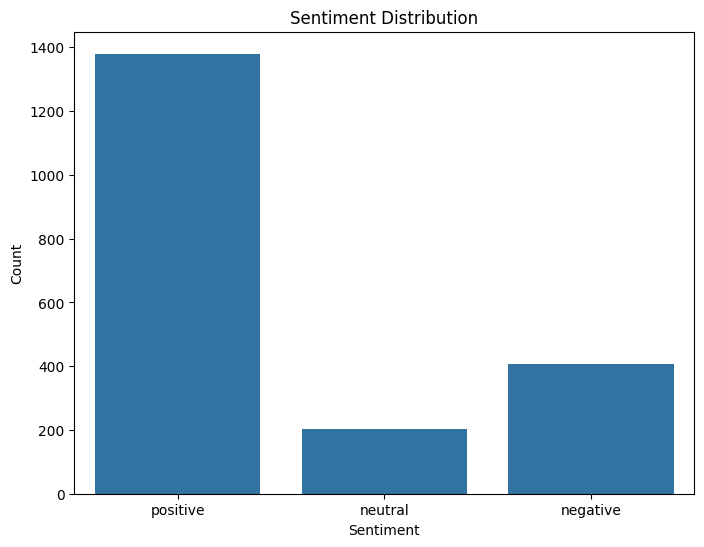

In [22]:
# Sentiment distribution

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

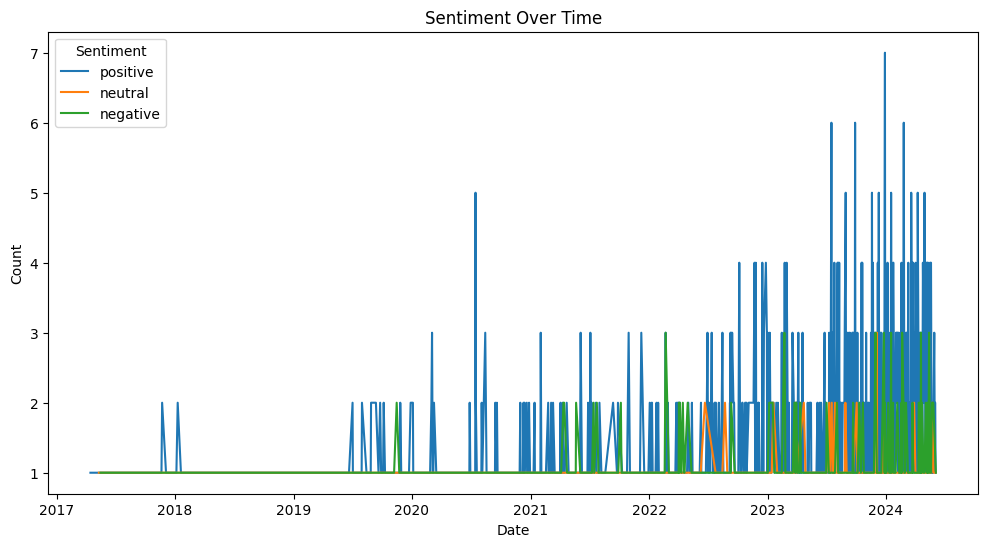

In [23]:
# Sentiment over time
# Group by date and sentiment, then count the occurrences
grouped_df = df.groupby(['date', 'sentiment']).size().reset_index(name='count')

# Plot the counts over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_df, x='date', y='count', hue='sentiment')
plt.title('Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# 4. Sentiment Prediction

## 4.1 Data Conversion and X-axis, Y-axis Distribution

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# Preprocess text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['translated_content'])


In [25]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])


In [26]:
X

<1992x4899 sparse matrix of type '<class 'numpy.float64'>'
	with 33518 stored elements in Compressed Sparse Row format>

In [27]:
y

array([2, 2, 2, ..., 1, 2, 2])

## 4.2 Train-Test Split

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
from collections import Counter
Counter(y_train).items()
Counter(y_test).items()

dict_items([(1, 36), (0, 85), (2, 278)])

In [30]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [31]:
# Make predictions
y_pred = model.predict(X_test)

In [32]:
# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

# Get feature importance
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()
sorted_coef_index

Accuracy: 0.7443609022556391
              precision    recall  f1-score   support

           0       0.83      0.28      0.42        85
           1       0.00      0.00      0.00        36
           2       0.74      0.98      0.84       278

    accuracy                           0.74       399
   macro avg       0.52      0.42      0.42       399
weighted avg       0.69      0.74      0.68       399



array([1812, 1840,  382, ..., 2808, 3599, 2801], dtype=int64)

In [33]:
print("Top 10 Positive words:\n", feature_names[sorted_coef_index[:-11:-1]])
print("\nTop 10 Negative words:\n", feature_names[sorted_coef_index[:10]])

Top 10 Positive words:
 ['not' 'return' 'nothing' 'overpriced' 'bad' 'amazon' 'already' 'issue'
 'instead' 'regret']

Top 10 Negative words:
 ['good' 'great' 'best' 'gaming' 'super' 'excellent' 'perfect' 'budget'
 'love' 'price']


In [34]:
# Get feature importance
feature_names = np.array(tfidf.get_feature_names_out())
coef = model.coef_

# For multi-class, get top features for each class
for idx, class_label in enumerate(model.classes_):
    sorted_coef_index = coef[idx].argsort()
    print(f"\nTop 10 Positive words for class '{class_label}':\n")
    print(feature_names[sorted_coef_index[:-11:-1]])
    print(f"\nTop 10 Negative words for class '{class_label}':\n")
    print(feature_names[sorted_coef_index[:10]])


Top 10 Positive words for class '0':

['not' 'return' 'nothing' 'overpriced' 'bad' 'amazon' 'already' 'issue'
 'instead' 'regret']

Top 10 Negative words for class '0':

['good' 'great' 'best' 'gaming' 'super' 'excellent' 'perfect' 'budget'
 'love' 'price']

Top 10 Positive words for class '1':

['large' 'ok' 'better' 'okay' 'piece' 'price' 'ram' 'lower' 'three' 'old']

Top 10 Negative words for class '1':

['best' 'great' 'excellent' 'perfect' 'product' 'good' 'new' 'time'
 'ihave' 'using']

Top 10 Positive words for class '2':

['good' 'great' 'best' 'excellent' 'perfect' 'super' 'gaming' 'amazing'
 'easy' 'fast']

Top 10 Negative words for class '2':

['not' 'return' 'better' 'okay' 'nothing' 'itis' 'instead' 'going' 'large'
 'bad']


This is giving incorrect result. Let's do sampling and see if the results change.

In [35]:
! pip install imblearn


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 4.3 Sampling

In [36]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(X,y)
print(x_resampled)
print(y_resampled)

  (0, 1237)	0.11751423468861999
  (0, 2165)	0.31146481108526236
  (0, 2527)	0.14848492743133143
  (0, 814)	0.12126844635880461
  (0, 4267)	0.13421222550747428
  (0, 4875)	0.09910949111255457
  (0, 868)	0.14848492743133143
  (0, 4456)	0.16275762935518862
  (0, 4764)	0.06644268428829395
  (0, 2446)	0.13421222550747428
  (0, 3076)	0.13696179128204433
  (0, 3773)	0.1438901436920889
  (0, 896)	0.06877242240261847
  (0, 516)	0.18828737102094564
  (0, 1904)	0.12126844635880461
  (0, 1831)	0.18090169684021992
  (0, 2772)	0.16275762935518862
  (0, 1121)	0.10441849059718021
  (0, 3032)	0.06813879836984313
  (0, 4693)	0.09342111465996975
  (0, 4593)	0.13212622611179262
  (0, 3796)	0.12268908935818715
  (0, 1002)	0.16275762935518862
  (0, 1461)	0.16275762935518862
  (0, 3250)	0.16275762935518862
  :	:
  (4139, 4310)	0.08817767500193506
  (4139, 2879)	0.07971259363601256
  (4139, 3064)	0.11247039792353221
  (4139, 2252)	0.10686445519901035
  (4139, 3405)	0.11311700811837061
  (4139, 3801)	0.1094917

In [37]:
from collections import Counter
Counter(y_resampled).items()

dict_items([(2, 1380), (1, 1380), (0, 1380)])

As we can see now, that all 3 categories have same amount of data. Let's do predictive analysis

## 4.4 Train-Test Split on Sampled Data

In [38]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [39]:
# Train a logistic regression model
model = LogisticRegression(max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

# Get feature importance
feature_names = np.array(tfidf.get_feature_names_out())
coef = model.coef_

# Get feature importance
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = model.coef_[0].argsort()
sorted_coef_index

print("Top 10 Positive words:\n", feature_names[sorted_coef_index[:-11:-1]])
print("\nTop 10 Negative words:\n", feature_names[sorted_coef_index[:10]])

# For multi-class, get top features for each class
# for idx, class_label in enumerate(model.classes_):
#     sorted_coef_index = coef[idx].argsort()
#     top_positive_words = feature_names[sorted_coef_index[:-11:-1]]
#     top_negative_words = feature_names[sorted_coef_index[:10]]
    
#     print(f"\nTop 10 words contributing positively to class '{class_label}':\n")
#     print(top_positive_words)
    
#     print(f"\nTop 10 words contributing negatively to class '{class_label}':\n")
#     print(top_negative_words)


Accuracy: 0.892512077294686
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       268
           1       0.89      0.97      0.93       272
           2       0.94      0.79      0.86       288

    accuracy                           0.89       828
   macro avg       0.90      0.89      0.89       828
weighted avg       0.90      0.89      0.89       828

Top 10 Positive words:
 ['not' 'nothing' 'return' 'amazon' 'bad' 'already' 'overpriced' 'even'
 'ordered' 'hard']

Top 10 Negative words:
 ['good' 'great' 'excellent' 'best' 'super' 'gaming' 'perfect' 'large'
 'price' 'ok']


In [40]:
! pip install xgboost


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 4.5 Preditions using Multiple Models

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



In [42]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='ovr'),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False)
}

# Train, predict and evaluate each model
model_accuracies = {}
classification_reports = {}
confusion_matrices = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    model_accuracies[model_name] = accuracy
    classification_reports[model_name] = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    confusion_matrices[model_name] = confusion_matrix(y_test, y_pred)

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))




Logistic Regression Results:
Accuracy: 0.892512077294686
              precision    recall  f1-score   support

           0       0.85      0.92      0.89       268
           1       0.89      0.97      0.93       272
           2       0.94      0.79      0.86       288

    accuracy                           0.89       828
   macro avg       0.90      0.89      0.89       828
weighted avg       0.90      0.89      0.89       828


Naive Bayes Results:
Accuracy: 0.8381642512077294
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       268
           1       0.83      0.94      0.88       272
           2       0.93      0.67      0.78       288

    accuracy                           0.84       828
   macro avg       0.85      0.84      0.84       828
weighted avg       0.85      0.84      0.83       828


SVM Results:
Accuracy: 0.9251207729468599
              precision    recall  f1-score   support

           0       0.89      0.

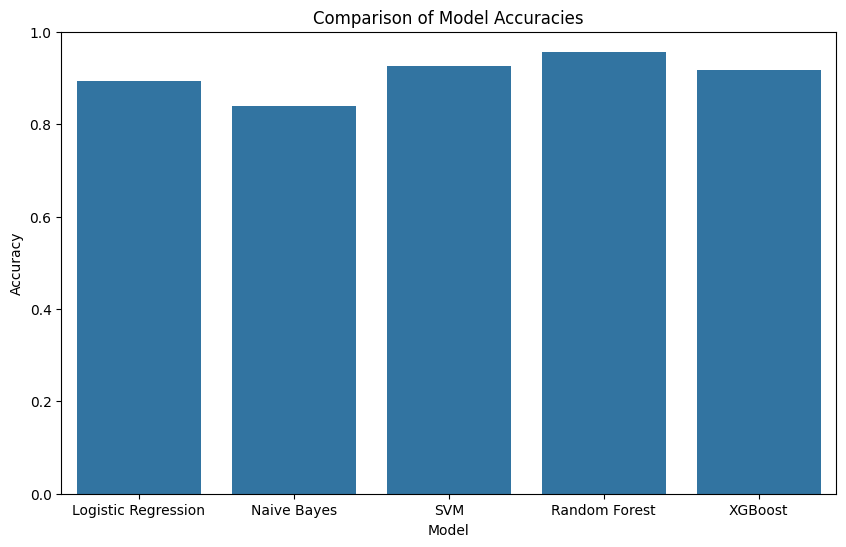

In [43]:
# Plotting accuracies
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()))
plt.title('Comparison of Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

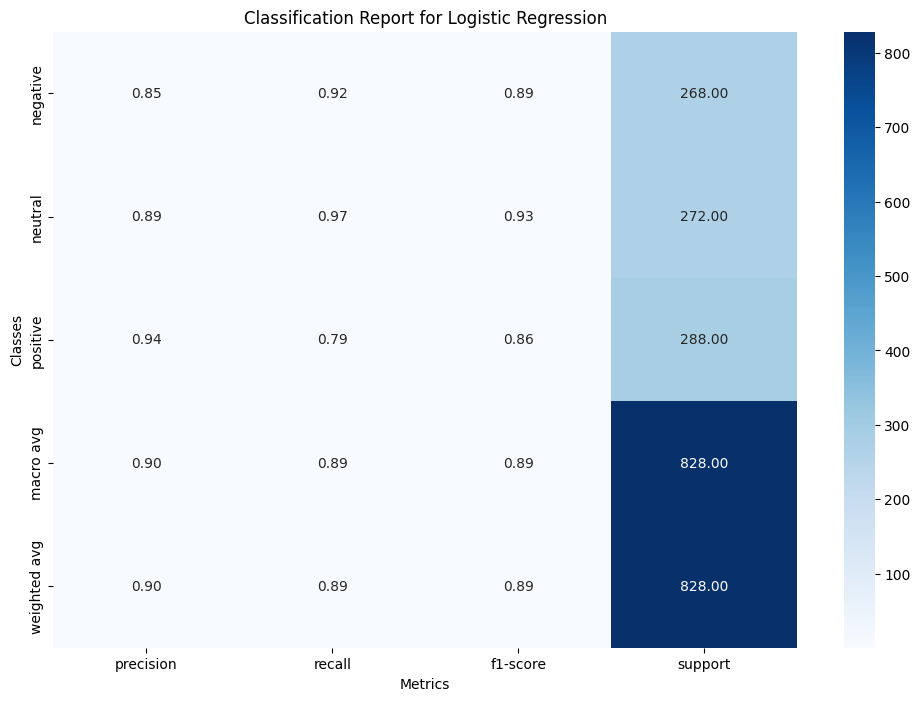

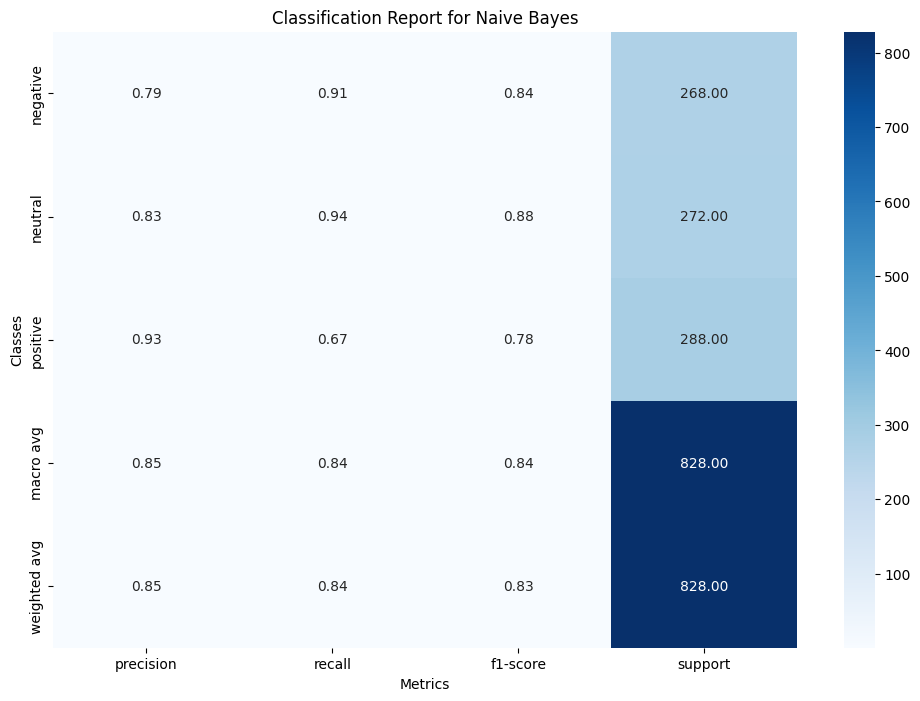

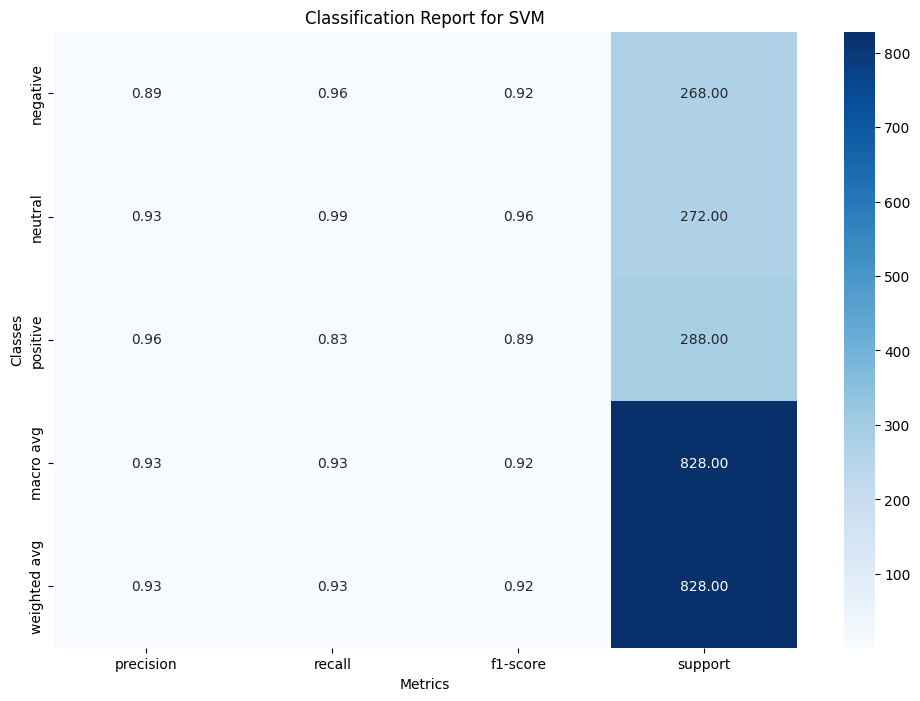

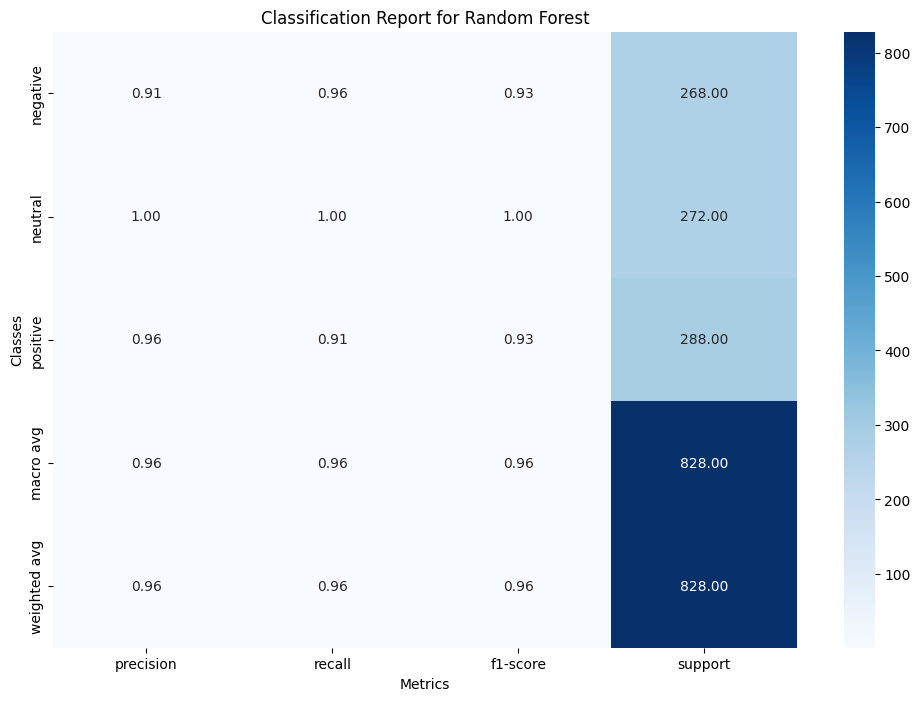

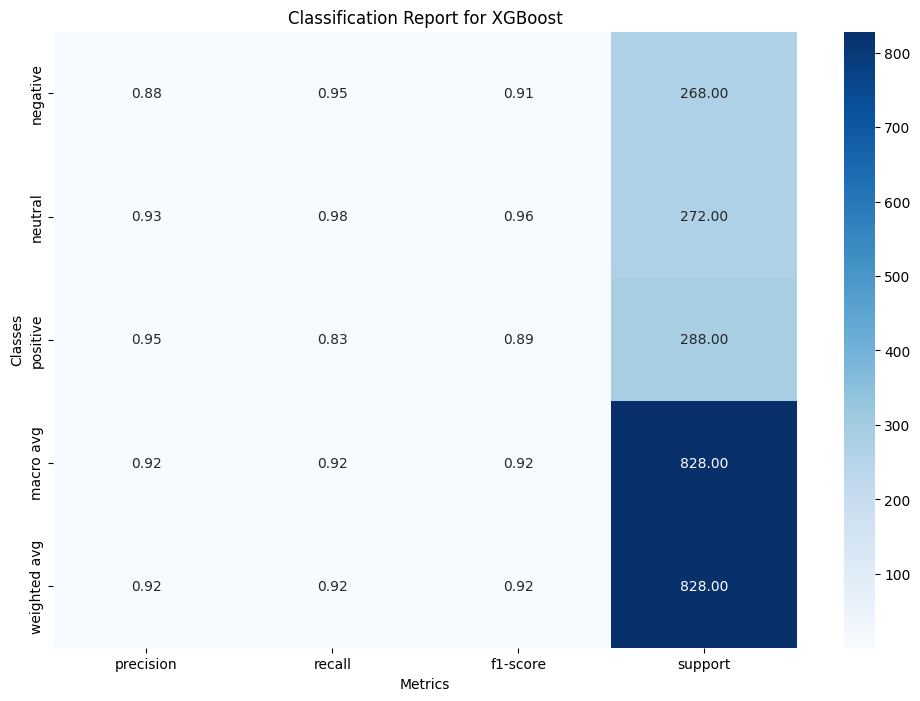

In [44]:
# Plot classification reports
for model_name, report in classification_reports.items():
    df_report = pd.DataFrame(report).transpose()
    df_report = df_report.drop(['accuracy'], errors='ignore')  # Drop accuracy row if exists
    df_report.reset_index(inplace=True)
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(df_report.iloc[:, 1:], annot=True, cmap='Blues', fmt='.2f', xticklabels=df_report.columns[1:], yticklabels=df_report['index'])
    plt.title(f'Classification Report for {model_name}')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()

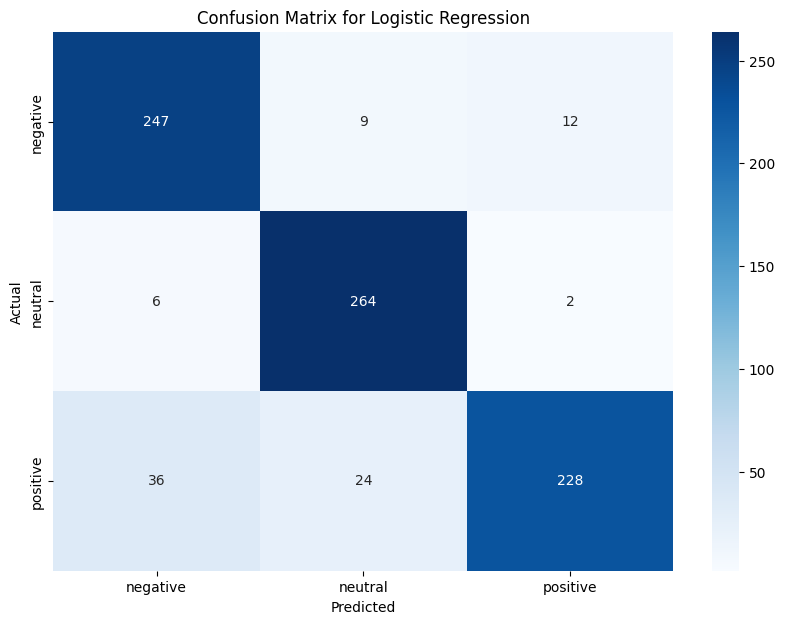

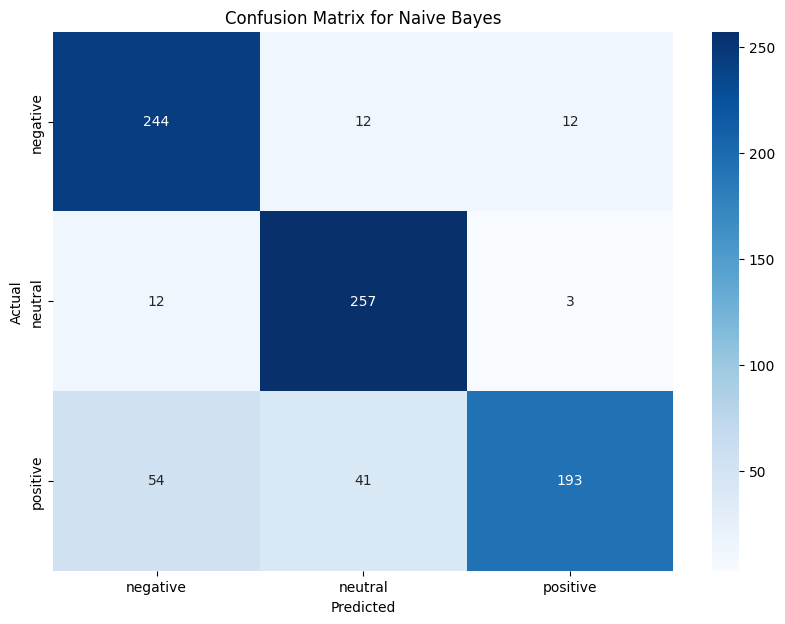

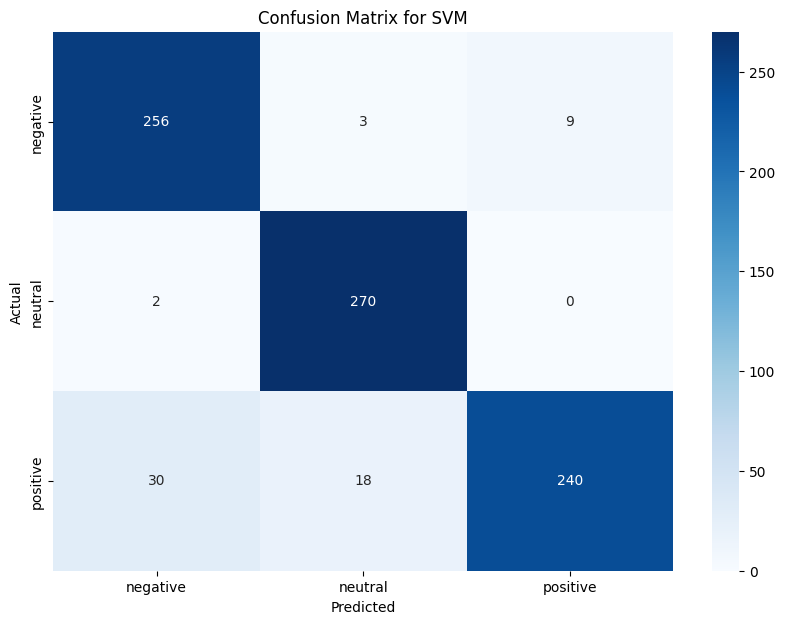

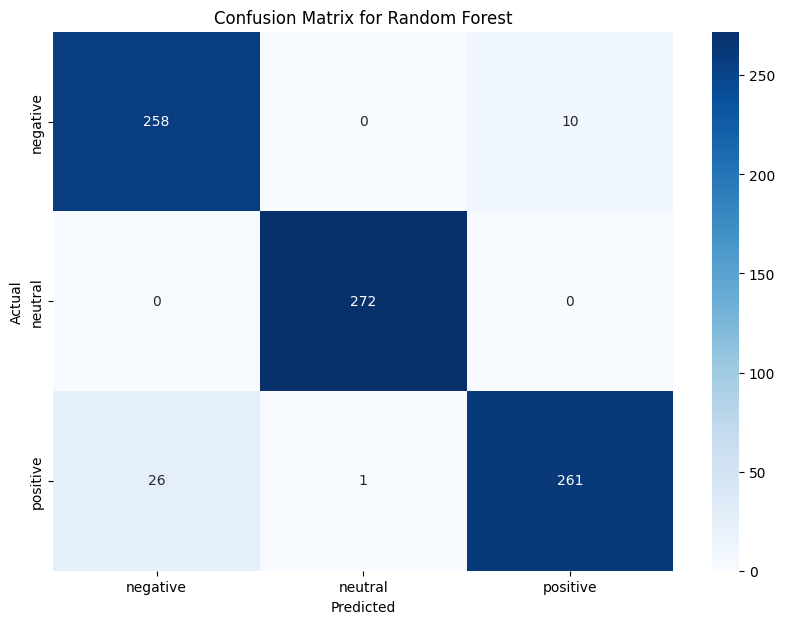

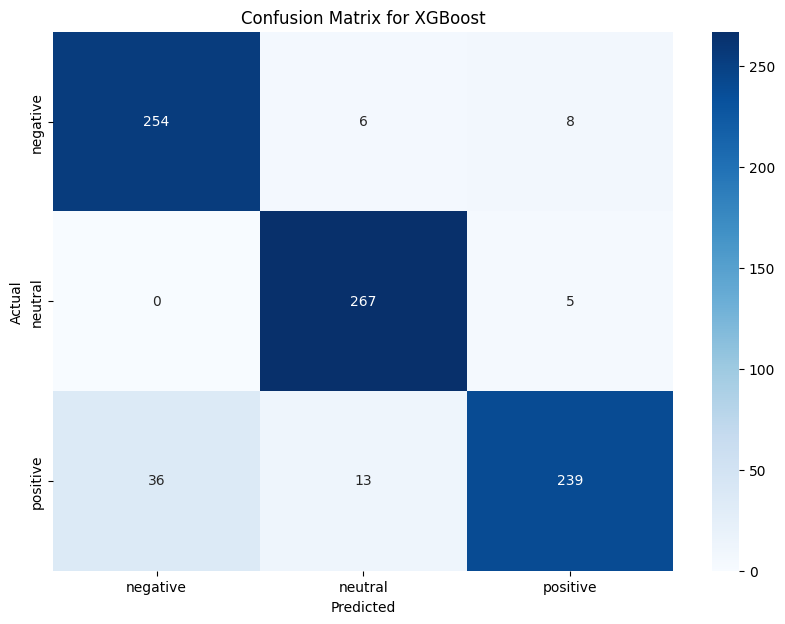

In [45]:
# Plot confusion matrices
for model_name, cm in confusion_matrices.items():
    df_cm = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# 5. Conclusion

*Random Forest* and *Support Vector Machine (SVM)* are the ***preferred*** models to be used in the prediction analysis on the current dataset.